# **Dataset Story:**

This dataset contains demographic and banking-related information of customers of a bank. This dataset can be used to understand the customer base of the bank and to predict customer churn. Customer churn is an important topic for banks to understand and address in order to retain customers and reduce customer loss. Analyzing this dataset and developing a machine learning model to predict churned customers based on various factors can be valuable for the bank's customer retention efforts.

# **Business Problem:**

Develop a machine learning model to predict whether a bank customer will churn or not.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, cross_validate,validation_curve
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score



warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)



# **EDA:**

In [2]:
df = pd.read_csv('/kaggle/input/bank-customer-churn-dataset/Bank Customer Churn Prediction.csv')
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [4]:
df.nunique()

customer_id         10000
credit_score          460
country                 3
gender                  2
age                    70
tenure                 11
balance              6382
products_number         4
credit_card             2
active_member           2
estimated_salary     9999
churn                   2
dtype: int64

In [5]:
df.isnull().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

In [6]:
def grab_col_names(dataframe, cat_th=10, car_th=30):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes not in ["O", 'datetime64[ns]']]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    binary_cols = [col for col in dataframe.columns if
                   dataframe[col].dtype not in [int, float] and dataframe[col].nunique() == 2]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    print(f'binary_cols: {len(binary_cols)}')

    return cat_cols, num_cols, cat_but_car, binary_cols

result = grab_col_names(df)
cat_cols, num_cols, cat_but_car = result[0], result[1], result[2]

Observations: 10000
Variables: 12
cat_cols: 6
num_cols: 6
cat_but_car: 0
num_but_cat: 4
binary_cols: 1


In [7]:
def cat_summary(dataframe, col_names):
    for col in col_names:
        print(pd.DataFrame({col: dataframe[col].value_counts(),
                            "Ratio": 100 * dataframe[col].value_counts() / len(dataframe)}))
        print("##########################################")
cat_summary(df, cat_cols)

         country  Ratio
country                
France      5014  50.14
Germany     2509  25.09
Spain       2477  24.77
##########################################
        gender  Ratio
gender               
Male      5457  54.57
Female    4543  45.43
##########################################
                 products_number  Ratio
products_number                        
1                           5084  50.84
2                           4590  45.90
3                            266   2.66
4                             60   0.60
##########################################
             credit_card  Ratio
credit_card                    
1                   7055  70.55
0                   2945  29.45
##########################################
               active_member  Ratio
active_member                      
1                       5151  51.51
0                       4849  48.49
##########################################
       churn  Ratio
churn              
0       7963  79.63
1    

In [8]:
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

for col in cat_cols:
    target_summary_with_cat(df, 'churn', col)

         TARGET_MEAN
country             
France      0.161548
Germany     0.324432
Spain       0.166734


        TARGET_MEAN
gender             
Female     0.250715
Male       0.164559


                 TARGET_MEAN
products_number             
1                   0.277144
2                   0.075817
3                   0.827068
4                   1.000000


             TARGET_MEAN
credit_card             
0               0.208149
1               0.201843


               TARGET_MEAN
active_member             
0                 0.268509
1                 0.142691


       TARGET_MEAN
churn             
0              0.0
1              1.0




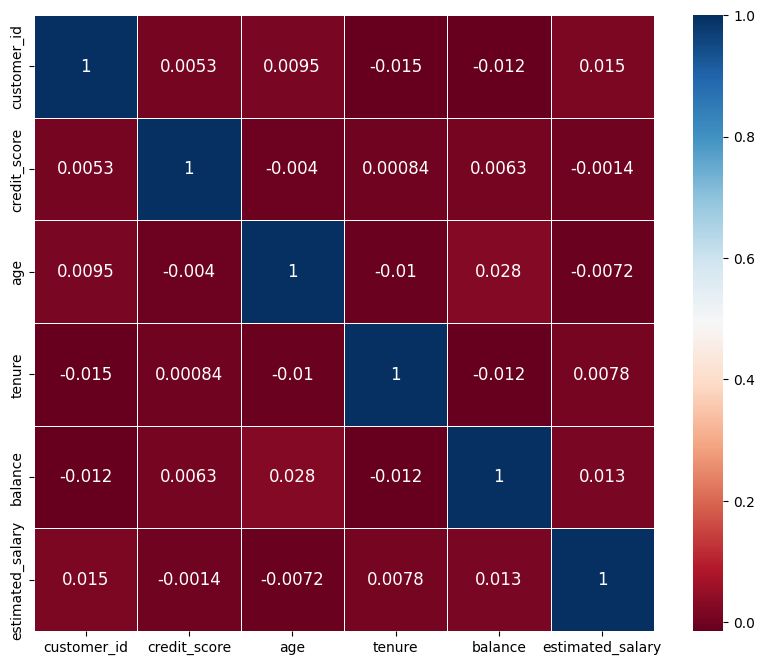

In [9]:
def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)
    
correlation_matrix(df, num_cols)


In [10]:
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

rare_analyser(df, 'churn', cat_cols=cat_cols)


country : 3
         COUNT   RATIO  TARGET_MEAN
country                            
France    5014  0.5014     0.161548
Germany   2509  0.2509     0.324432
Spain     2477  0.2477     0.166734


gender : 2
        COUNT   RATIO  TARGET_MEAN
gender                            
Female   4543  0.4543     0.250715
Male     5457  0.5457     0.164559


products_number : 4
                 COUNT   RATIO  TARGET_MEAN
products_number                            
1                 5084  0.5084     0.277144
2                 4590  0.4590     0.075817
3                  266  0.0266     0.827068
4                   60  0.0060     1.000000


credit_card : 2
             COUNT   RATIO  TARGET_MEAN
credit_card                            
0             2945  0.2945     0.208149
1             7055  0.7055     0.201843


active_member : 2
               COUNT   RATIO  TARGET_MEAN
active_member                            
0               4849  0.4849     0.268509
1               5151  0.5151     0.142691


c

<Axes: >

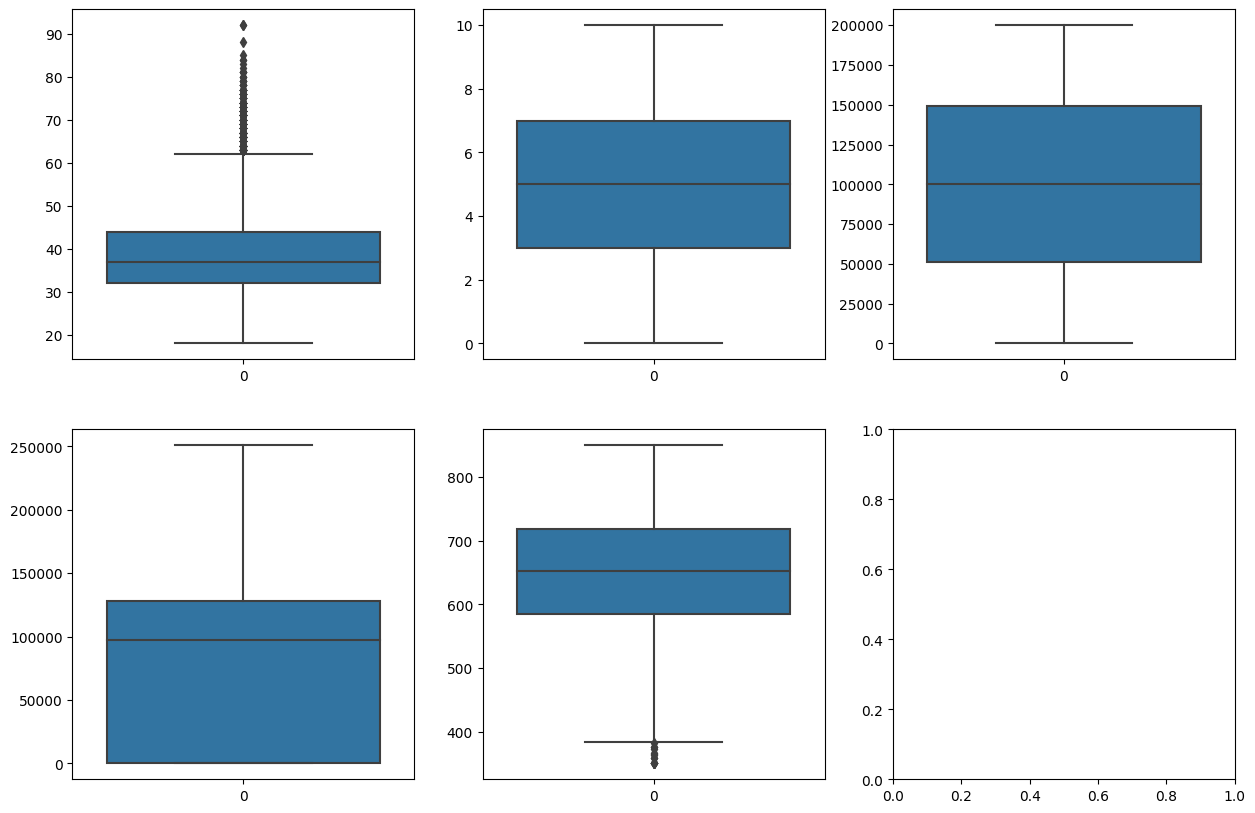

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
sns.boxplot(data=df['age'], ax=ax[0][0])
sns.boxplot(data=df['tenure'], ax=ax[0][1])
sns.boxplot(data=df['estimated_salary'], ax=ax[0][2])
sns.boxplot(data=df['balance'], ax=ax[1][0])
sns.boxplot(data=df['credit_score'], ax=ax[1][1])

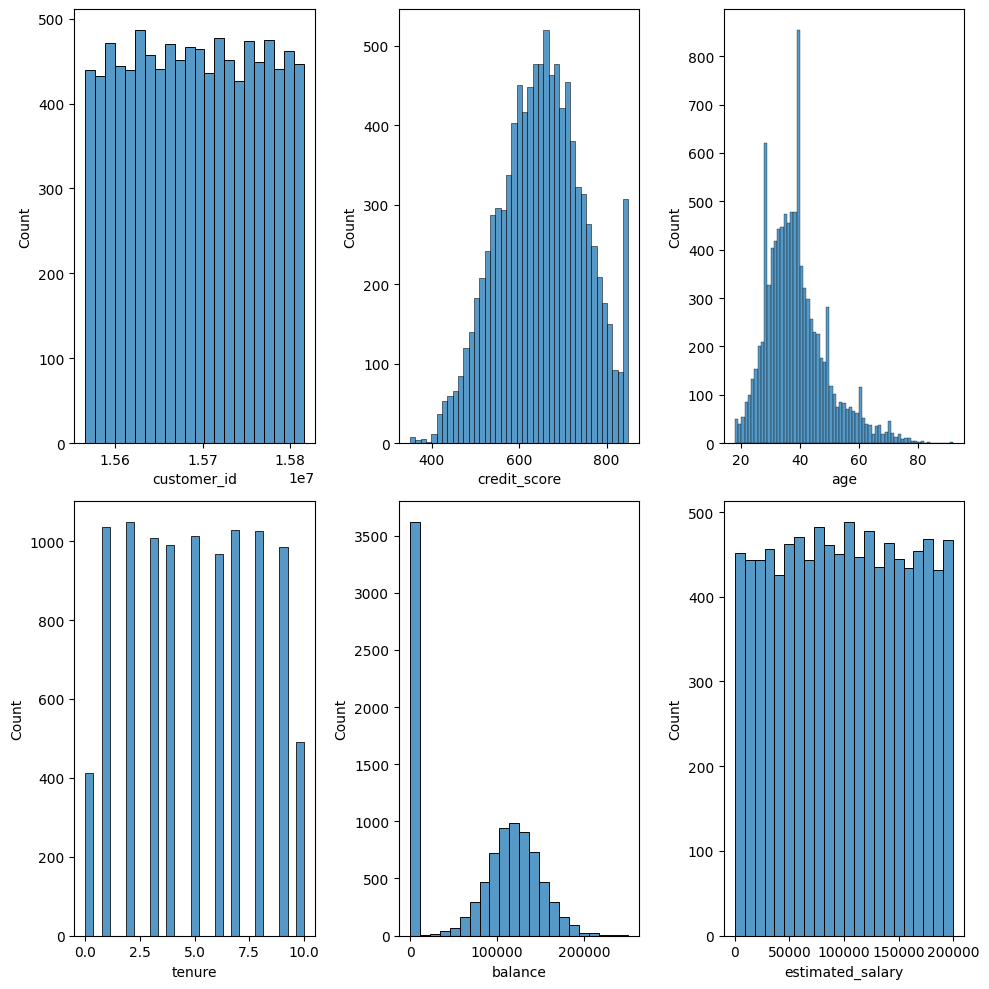

In [12]:
def plot_numerical_col(dataframe, num_cols, plot_type='hist'):
    num_cols_count = len(num_cols)
    num_rows = num_cols_count // 3
    num_rows += 1 if num_cols_count % 3 != 0 else 0  # Eğer sütun sayısı 3'e tam bölünmüyorsa bir ek satır oluştur.


    col_groups = [num_cols[i:i+12] for i in range(0, num_cols_count, 12)]

    for group in col_groups:
        fig, axes = plt.subplots(num_rows, 3, figsize=(10, 10))
        axes = axes.flatten()

        for i, col in enumerate(group):
            if plot_type == 'hist':
                sns.histplot(data=dataframe[col], ax=axes[i])
            elif plot_type == 'kde':
                sns.kdeplot(data=dataframe[col], ax=axes[i])
            elif plot_type == 'box':
                sns.boxplot(data=dataframe[col], ax=axes[i])
            else:
                print("Geçersiz grafik türü. Lütfen 'hist', 'kde', veya 'box' olarak belirtin.")
                return
            axes[i].set_xlabel(col)

        for j in range(len(group), num_rows * 3):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()
        
plot_numerical_col(df, num_cols)

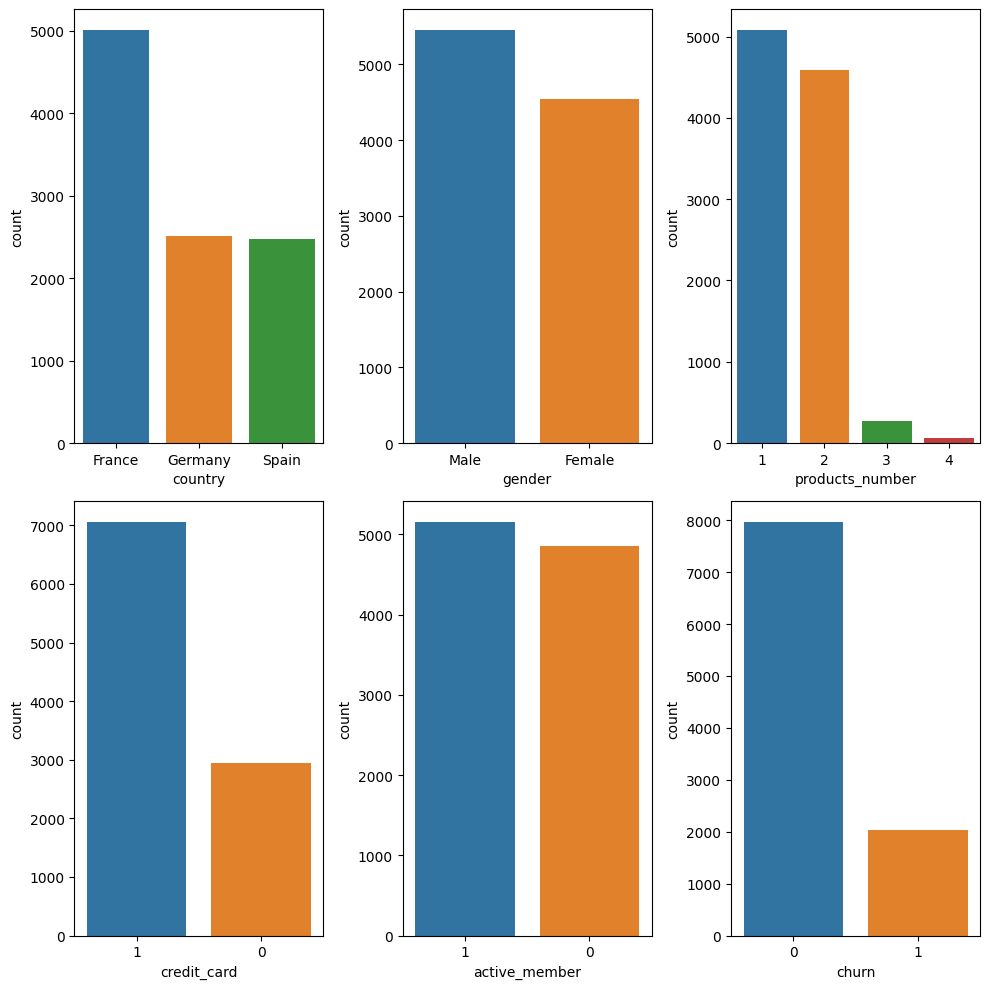

In [13]:
def plot_categoric_col(dataframe, cat_cols):
    cat_cols_count = len(cat_cols)
    cat_rows = cat_cols_count // 3
    cat_rows += 1 if cat_cols_count % 3 != 0 else 0  # Eğer sütun sayısı 3'e tam bölünmüyorsa bir ek satır oluştur.

    fig, axes = plt.subplots(cat_rows, 3, figsize=(10, 10), squeeze=True)
    axes = axes.flatten()

    for i, col in enumerate(cat_cols):
        sns.countplot(data=dataframe, x=col, ax=axes[i], order=dataframe[col].value_counts().index)
        axes[i].set_xlabel(col)

    plt.tight_layout()
    plt.show()

plot_categoric_col(df, cat_cols=cat_cols)

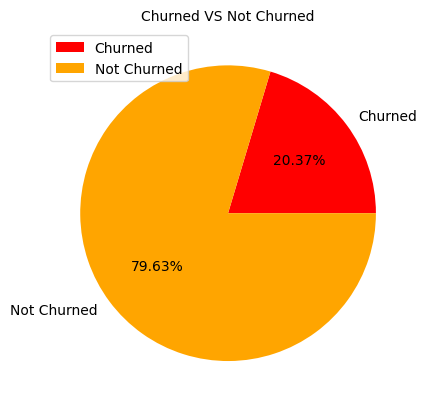

In [14]:
sizes = [df.churn[df['churn']==1].count(), df.churn[df['churn']==0].count()]
labels = ['Churned', 'Not Churned']
colors = ['red', 'orange']

plt.pie(sizes, labels=labels, autopct='%.2f%%', colors=colors)
plt.legend(loc='upper left')
plt.title("Churned VS Not Churned", size=10)
plt.show()

# **FEATURE ENGINEERING:**

In [15]:
df.loc[df['products_number'] == 4, 'products_number'] = 3


df['credit_score_seg'] = pd.cut(df['credit_score'], bins=[349, 500, 590, 620, 660, 690, 720, np.inf],
                                labels=['A', 'B', 'C', 'D', 'E', 'F', 'G'])

df['balance_seg'] = pd.cut(df['balance'], bins=[-1, 50000, 90000, 127000, np.inf],
                           labels=['A', 'B', 'C', 'D'])

df['age_seg'] = pd.cut(df['age'], bins=[17, 36, 55, np.inf],
                       labels=['A', 'B', 'C'])

df['tenure_seg'] = pd.cut(df['tenure'], bins=[-1, 3, 5, 7, np.inf],
                          labels=['A', 'B', 'C', 'D'])

df_final = df.drop('customer_id', axis=1)

In [16]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first, dtype=int)
    return dataframe

def label_encoder(dataframe, binary_col, info=False):
    labelencoder = LabelEncoder()

    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    if info:
        d1, d2 = labelencoder.inverse_transform([0, 1])
        print(f'{binary_col}\n0:{d1}, 1:{d2}')
    return dataframe

In [17]:
df_final = one_hot_encoder(df_final, ['country', 'gender','age_seg'], drop_first=True)

label_encoder(df_final, 'credit_score_seg')
label_encoder(df_final, 'balance_seg')
label_encoder(df_final, 'tenure_seg')

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,credit_score_seg,balance_seg,tenure_seg,country_Germany,country_Spain,gender_Male,age_seg_B,age_seg_C
0,619,42,2,0.00,1,1,1,101348.88,1,2,0,0,0,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,2,1,0,0,1,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,3,3,0,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,5,0,0,0,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,6,2,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,6,0,1,0,0,1,1,0
9996,516,35,10,57369.61,1,1,1,101699.77,0,1,1,3,0,0,1,0,0
9997,709,36,7,0.00,1,0,1,42085.58,1,5,0,2,0,0,0,0,0
9998,772,42,3,75075.31,2,1,0,92888.52,1,6,1,0,1,0,1,1,0


# **MODELING:**

In [18]:
y = df_final['churn']
X = df_final.drop(columns=['churn'], axis=1)


# **No Smote:**

In [19]:
model = LGBMClassifier(verbose=-1).fit(X, y)
cv_results = cross_validate(model, X, y, cv=3, scoring=["accuracy", "f1", "roc_auc"])
f1 = cv_results['test_f1'].mean()
auc = cv_results['test_roc_auc'].mean()
accuracy = cv_results['test_accuracy'].mean()
print(f'f1: {f1:.2f}')
print(f'auc: {auc:.2f}')
print(f'accuracy: {accuracy:.2f}')

f1: 0.59
auc: 0.86
accuracy: 0.86


#### **Hyperparameter Optimization**

In [20]:
lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500]}

gs_best = GridSearchCV(model, lightgbm_params, cv=3, n_jobs=-1, verbose=False).fit(X, y)
final_model = model.set_params(**gs_best.best_params_)

cv_results = cross_validate(final_model, X, y, cv=3, scoring=['accuracy', 'f1', 'roc_auc'])
f1 = cv_results['test_f1'].mean()
auc = cv_results['test_roc_auc'].mean()
accuracy = cv_results['test_accuracy'].mean()

print(f'f1: {f1:.2f}')
print(f'auc: {auc:.2f}')
print(f'accuracy: {accuracy:.2f}')

f1: 0.57
auc: 0.86
accuracy: 0.86


#### **FEATURE IMPORTANCE:**

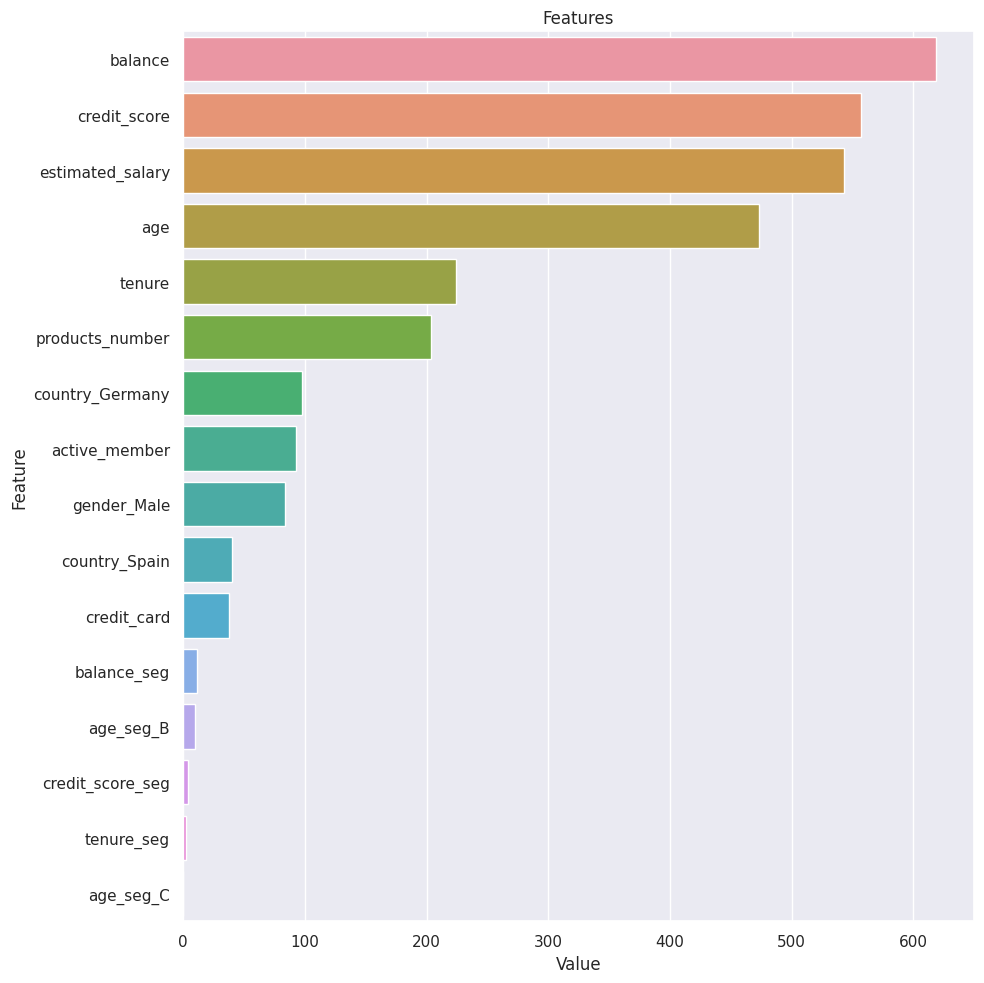

In [21]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(model, X)

#### **VALIDATION CURVE:**

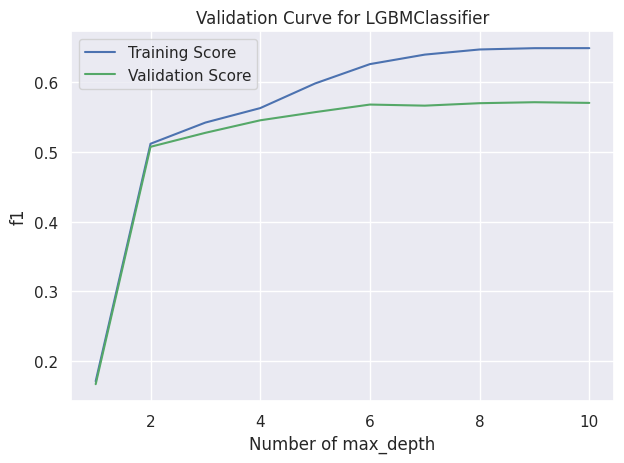

In [22]:
def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=3):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')

    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='g')

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show(block=True)


val_curve_params(model, X, y, "max_depth", range(1, 11), scoring="f1")

# **With Smote:**

In [23]:
oversample = SMOTE()
X_smote, y_smote = oversample.fit_resample(X, y)

model = LGBMClassifier(verbose=-1).fit(X_smote, y_smote)
cv_results = cross_validate(model, X_smote, y_smote, cv=3, scoring=["accuracy", "f1", "roc_auc"])
f1 = cv_results['test_f1'].mean()
auc = cv_results['test_roc_auc'].mean()
accuracy = cv_results['test_accuracy'].mean()
print(f'f1: {f1:.2f}')
print(f'auc: {auc:.2f}')
print(f'accuracy: {accuracy:.2f}')

f1: 0.82
auc: 0.93
accuracy: 0.85


#### **Hyperparameter Optimization**

In [24]:
lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500]}

gs_best = GridSearchCV(model, lightgbm_params, cv=3, n_jobs=-1, verbose=False).fit(X_smote, y_smote)
final_model = model.set_params(**gs_best.best_params_)

cv_results = cross_validate(final_model, X_smote, y_smote, cv=3, scoring=['accuracy', 'f1', 'roc_auc'])
f1 = cv_results['test_f1'].mean()
auc = cv_results['test_roc_auc'].mean()
accuracy = cv_results['test_accuracy'].mean()

print(f'f1: {f1:.2f}')
print(f'auc: {auc:.2f}')
print(f'accuracy: {accuracy:.2f}')


f1: 0.84
auc: 0.94
accuracy: 0.86


#### **FEATURE IMPORTANCE:**

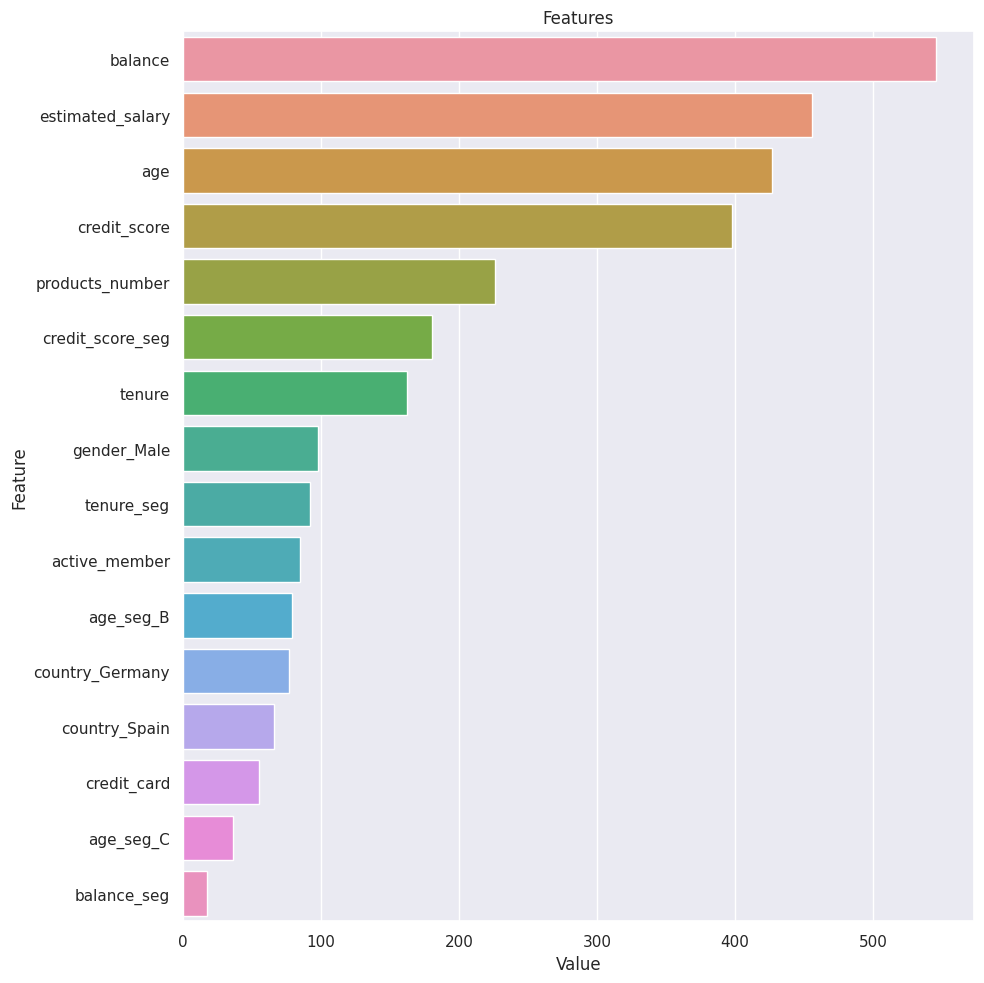

In [25]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(model, X_smote)

#### **VALIDATION CURVE:**

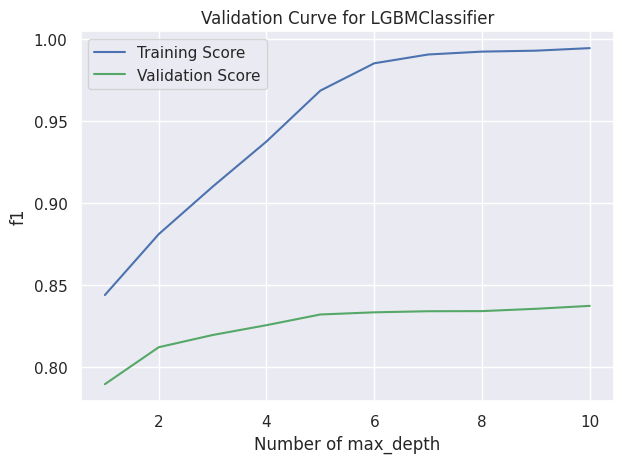

In [26]:
def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=3):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')

    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='g')

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show(block=True)


val_curve_params(model, X_smote, y_smote, "max_depth", range(1, 11), scoring="f1")